# Bibliotekų importavimas

In [2]:
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from Bio.PDB import PDBIO, Chain, Model, Residue, Atom
from collections import Counter
import random
import time
import pandas as pd
import copy
import math
import py3Dmol

# Baltymo seka

In [3]:
sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

# Baltymo sekos energijos apskaičiavimas

APSKAIČIAVIMO PRINCIPAS: energijos apskaičiavimui pirmiausia apibrėžta atsitiktinės sąveikos matrica, vaizduojanti sąveikos stiprumą tarp aminorūgščių porų. Proteino sekos energija apskaičiuojama susumuojant gretimų aminorūgščių sąveikos stiprumą pagal sąveikos matricą.

In [4]:
random.seed(0)

interaction_matrix = {
    aa1: {aa2: random.uniform(-1, 1) for aa2 in "ACDEFGHIKLMNPQRSTVWY"} 
    for aa1 in "ACDEFGHIKLMNPQRSTVWY"
}

def compute_energy(seq, interaction_matrix):
    energy = 0
    for i in range(len(seq) - 1):
        aa1 = seq[i]
        aa2 = seq[i+1]
        energy += interaction_matrix[aa1][aa2]
    return energy

energy = compute_energy(sequence, interaction_matrix)
print(f"Apskaičiuota baltymo sekos energija: {energy}")


Apskaičiuota baltymo sekos energija: -3.1060917005571254


# Baltymo sekos grafinė analizė

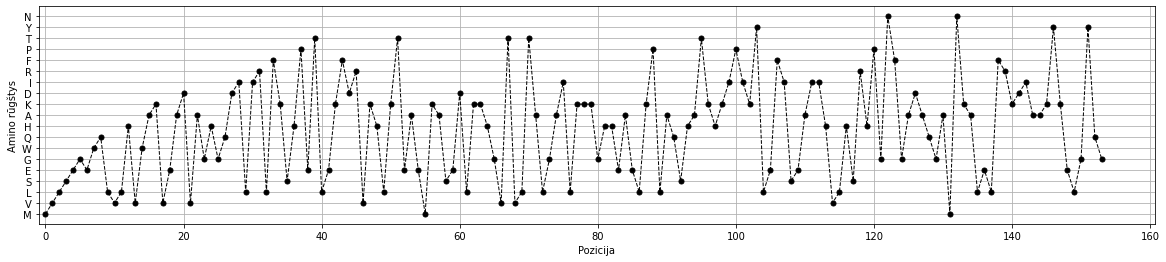

In [6]:
indices = list(range(len(sequence)))

plt.figure(figsize=(20, 4))
plt.plot(indices, list(sequence), 'ko--', linewidth=1, markersize=5)
plt.xlabel("Pozicija")
plt.ylabel("Amino rūgštys")
plt.grid(True)

plt.xlim(left=-1) 

plt.show()

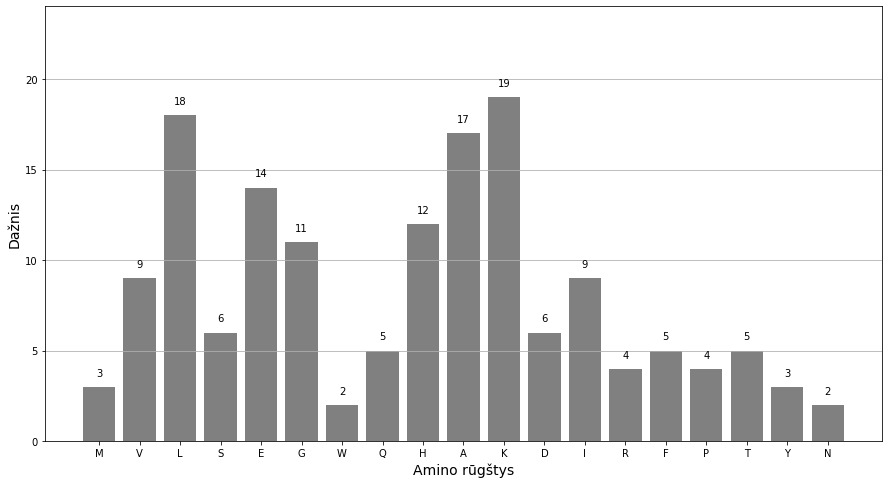

In [7]:
aa_freq = {}
for aa in sequence:
    aa_freq[aa] = aa_freq.get(aa, 0) + 1

plt.figure(figsize=(15, 8)) 
bars = plt.bar(aa_freq.keys(), aa_freq.values(), color='grey')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.ylim(0, max(aa_freq.values()) + 5)

plt.xlabel("Amino rūgštys", fontsize=14) 
plt.ylabel("Dažnis", fontsize=14)  
plt.grid(axis='y')
plt.show()

# Skruzdžių kolonijos algoritmas

VEIKIMO PRINCIPAS: inicijuojama baltymo seka pagal tinklelį. Vėliau algoritmas iteratyviai konstruoja baltymo sulenkimus, judindamas amino rūgštis tinklelyje, atsižvelgiant į energijos skaičiavimus ir feromonų lygį

H/P seka

In [13]:
def aco_protein_folding():
    random.seed(0)

    sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

    hp_sequence = ''
    for amino_acid in sequence:
        if amino_acid in ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']:
            hp_sequence += 'H'
        else:
            hp_sequence += 'P'

    sequence = hp_sequence
    n = len(sequence)

    grid_size = 2 * n
    start_position = (grid_size // 2, grid_size // 2)

    def energy(folding):
        e = 0
        for i, (x1, y1) in enumerate(folding):
            for j, (x2, y2) in enumerate(folding):
                if abs(x1 - x2) + abs(y1 - y2) == 1 and i != j:
                    if sequence[i] == sequence[j]:
                        e -= 1
                    else:
                        e += 1
        return e / 2

    def move(folding, position):
        x, y = folding[position]
        moves = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        valid_moves = [m for m in moves if m not in folding and 0 <= m[0] < grid_size and 0 <= m[1] < grid_size]
        return valid_moves

    def construct_solution():
        folding = [start_position]
        for i in range(1, n):
            current_moves = move(folding, i-1)
            if not current_moves:
                return construct_solution()
            move_probs = []
            for m in current_moves:
                prob = (pheromones[(i-1, m)] ** alpha) * (2 ** (-energy(folding + [m]) + 1e-10)) ** beta
                move_probs.append(prob)
            move_probs = [p + 1e-10 for p in move_probs]
            total_prob = sum(move_probs)
            move_probs = [p / total_prob for p in move_probs]
            selected_move = random.choices(current_moves, weights=move_probs)[0]
            folding.append(selected_move)
        return folding

    best_energy = float('inf')
    best_solution = None

    combinations = [
        (1.5, 2, 0.3, 5),
        (1.5, 3, 0.7, 7),
        (1, 2, 0.3, 4),
        (1, 3, 0.5, 6),
        (1.5, 2, 0.5, 8),
        (2, 3, 0.4, 5),
        (1, 1, 0.6, 7),
        (1.7, 2.5, 0.5, 6),
        (0.9, 1.8, 0.4, 7),
        (1.3, 2.3, 0.6, 5),
        (1.8, 3.2, 0.7, 6),
        (1.2, 2.8, 0.5, 7),
        (1.6, 1.9, 0.6, 8),
        (1.4, 3.1, 0.3, 5),
        (0.8, 2.2, 0.4, 6),
        (1.9, 2.6, 0.6, 7),
        (1.1, 1.7, 0.5, 8),
        (1.3, 2.4, 0.6, 5),
        (1.5, 2.9, 0.7, 6),
        (1.0, 3.0, 0.5, 7)
    ]

    pheromone_stats = []

    for idx, (alpha, beta, evaporation, num_ants) in enumerate(combinations):
        print(f"Testing combination {idx + 1}/{len(combinations)} => alpha: {alpha}, beta: {beta}, evaporation: {evaporation}, num_ants: {num_ants}")

        pheromones = {(i, (x, y)): 1.0 for i in range(n) for x in range(grid_size) for y in range(grid_size)}
        solutions = []
        for _ in range(num_ants):
            solution = construct_solution()
            solutions.append(solution)
        best_solution_this_iter = min(solutions, key=energy)
        if energy(best_solution_this_iter) < best_energy:
            best_solution = best_solution_this_iter
            best_energy = energy(best_solution_this_iter)
    
        for key in pheromones:
            pheromones[key] = max(1e-10, pheromones[key] * (1 - evaporation))
    
        for solution in solutions:
            for i, position in enumerate(solution[:-1]):
                next_position = solution[i + 1]
                pheromones[(i, next_position)] += 1.0 / (energy(solution) + 1e-10)

        pheromone_values = list(pheromones.values())
        max_pheromone = max(pheromone_values)
        min_pheromone = min(pheromone_values)
        avg_pheromone = sum(pheromone_values) / len(pheromone_values)
        pheromone_stats.append((max_pheromone, min_pheromone, avg_pheromone))
    
        print(f"  Best Energy for this combination: {best_energy}")
        print(f"  Max Pheromone: {max_pheromone:.2f}, Min Pheromone: {min_pheromone:.2f}, Average Pheromone: {avg_pheromone:.2f}")

    print("\nBest solution:")
    for i, (x, y) in enumerate(best_solution):
        print(f"  Amino Acid {i+1}: Position ({x}, {y})")
    print(f"\nBest Energy: {best_energy}")

    return best_energy, best_solution

execution_times = []
best_energies = []
best_solutions = []

for i in range(10):
    print(f"Run {i+1}...")
    start_time = time.time()
    best_energy, best_solution = aco_protein_folding()
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times.append(execution_time)
    best_energies.append(best_energy)
    best_solutions.append(best_solution)

df = pd.DataFrame({
    'Run': list(range(1, 11)),
    'Execution Time (s)': execution_times,
    'Best Energy': best_energies,
    'Best Solution': best_solutions
})

df.to_csv('aco_results_HP.csv', index=False)

print(df)

Run 1...
Testing combination 1/20 => alpha: 1.5, beta: 2, evaporation: 0.3, num_ants: 5
  Best Energy for this combination: -22.0
  Max Pheromone: 0.70, Min Pheromone: 0.47, Average Pheromone: 0.70
Testing combination 2/20 => alpha: 1.5, beta: 3, evaporation: 0.7, num_ants: 7
  Best Energy for this combination: -29.0
  Max Pheromone: 0.30, Min Pheromone: 0.11, Average Pheromone: 0.30
Testing combination 3/20 => alpha: 1, beta: 2, evaporation: 0.3, num_ants: 4
  Best Energy for this combination: -29.0
  Max Pheromone: 0.70, Min Pheromone: 0.60, Average Pheromone: 0.70
Testing combination 4/20 => alpha: 1, beta: 3, evaporation: 0.5, num_ants: 6
  Best Energy for this combination: -30.0
  Max Pheromone: 0.50, Min Pheromone: 0.38, Average Pheromone: 0.50
Testing combination 5/20 => alpha: 1.5, beta: 2, evaporation: 0.5, num_ants: 8
  Best Energy for this combination: -30.0
  Max Pheromone: 0.50, Min Pheromone: -0.63, Average Pheromone: 0.50
Testing combination 6/20 => alpha: 2, beta: 3, ev

Apskaičiuotos energijos vizualizavimas kiekvienai kombinacijai

In [14]:
combinations_dataHP = [
    {'combination': 1, 'best_energy': -22.0},
    {'combination': 2, 'best_energy': -29.0},
    {'combination': 3, 'best_energy': -29.0},
    {'combination': 4, 'best_energy': -30.0},
    {'combination': 5, 'best_energy': -30.0},
    {'combination': 6, 'best_energy': -32.0},
    {'combination': 7, 'best_energy': -32.0},
    {'combination': 8, 'best_energy': -32.0},
    {'combination': 9, 'best_energy': -32.0},
    {'combination': 10, 'best_energy': -32.0},
    {'combination': 11, 'best_energy': -36.0},
    {'combination': 12, 'best_energy': -36.0},
    {'combination': 13, 'best_energy': -36.0},
    {'combination': 14, 'best_energy': -36.0},
    {'combination': 15, 'best_energy': -36.0},
    {'combination': 16, 'best_energy': -36.0},
    {'combination': 17, 'best_energy': -36.0},
    {'combination': 18, 'best_energy': -36.0},
    {'combination': 19, 'best_energy': -36.0},
    {'combination': 20, 'best_energy': -43.0}
]

In [15]:
sorted_combinationsHP = sorted(combinations_dataHP, key=lambda x: x['best_energy'])

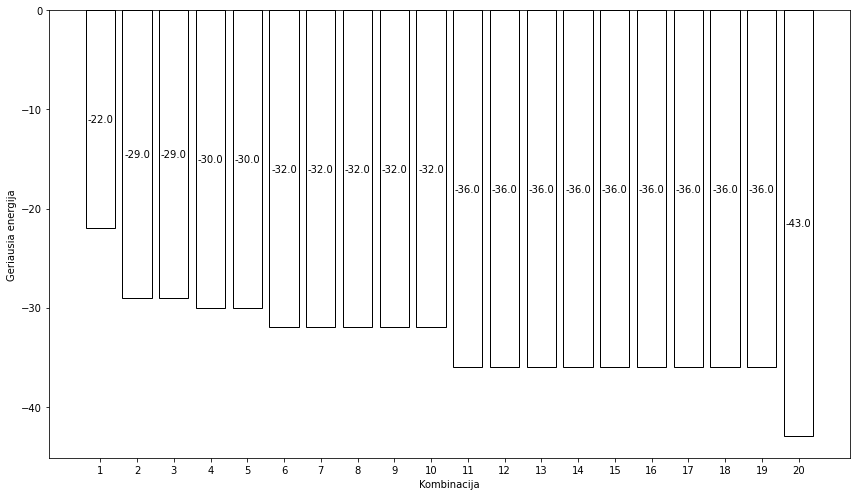

In [16]:
energies = [combo['best_energy'] for combo in sorted_combinationsHP]
combination_numbers = [combo['combination'] for combo in sorted_combinationsHP]

plt.figure(figsize=(12, 7))

bars = plt.bar(combination_numbers, energies, color='white', edgecolor='black')

plt.xlabel('Kombinacija')
plt.ylabel('Geriausia energija')
plt.xticks(list(range(1, 21)))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, round(yval, 2), ha='center', va='center', color='black')

plt.tight_layout() 
plt.show()

H/P/+/- seka

In [1]:
def aco_protein_folding():
    random.seed(0)

    sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

    def classify_amino_acid(aa):
        hydrophobic = ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']
        polar = ['S', 'T', 'Y', 'N', 'Q']
        positive = ['K', 'R', 'H']
        negative = ['D', 'E']

        if aa in hydrophobic:
            return 'H'
        elif aa in polar:
            return 'P'
        elif aa in positive:
            return '+'
        elif aa in negative:
            return '-'

    sequence = ''.join([classify_amino_acid(aa) for aa in sequence])
    n = len(sequence)

    grid_size = 2 * n
    start_position = (grid_size // 2, grid_size // 2)

    interaction_matrix = {
        'H': {'H': -1, 'P': 0.5, '+': 0.5, '-': 0.5},
        'P': {'H': 0.5, 'P': 0, '+': -0.5, '-': -0.5},
        '+': {'H': 0.5, 'P': -0.5, '+': 0, '-': -1},
        '-': {'H': 0.5, 'P': -0.5, '+': -1, '-': 0}
    }


    def energy(folding):
        e = 0
        for i, (x1, y1) in enumerate(folding):
            for j, (x2, y2) in enumerate(folding):
                if abs(x1 - x2) + abs(y1 - y2) == 1 and i != j:
                    if sequence[i] == sequence[j]:
                        e -= 1
                    else:
                        e += 1
        return e / 2

    def move(folding, position):
        x, y = folding[position]
        moves = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        valid_moves = [m for m in moves if m not in folding and 0 <= m[0] < grid_size and 0 <= m[1] < grid_size]
        return valid_moves

    def construct_solution():
        folding = [start_position]
        for i in range(1, n):
            current_moves = move(folding, i-1)
            if not current_moves:
                return construct_solution()
            move_probs = []
            for m in current_moves:
                prob = (pheromones[(i-1, m)] ** alpha) * (2 ** (-energy(folding + [m]) + 1e-10)) ** beta
                move_probs.append(prob)
            move_probs = [p + 1e-10 for p in move_probs]
            total_prob = sum(move_probs)
            move_probs = [p / total_prob for p in move_probs]
            selected_move = random.choices(current_moves, weights=move_probs)[0]
            folding.append(selected_move)
        return folding

    best_energy = float('inf')
    best_solution = None

    combinations = [
        (1.5, 2, 0.3, 5),
        (1.5, 3, 0.7, 7),
        (1, 2, 0.3, 4),
        (1, 3, 0.5, 6),
        (1.5, 2, 0.5, 8),
        (2, 3, 0.4, 5),
        (1, 1, 0.6, 7),
        (1.7, 2.5, 0.5, 6),
        (0.9, 1.8, 0.4, 7),
        (1.3, 2.3, 0.6, 5),
        (1.8, 3.2, 0.7, 6),
        (1.2, 2.8, 0.5, 7),
        (1.6, 1.9, 0.6, 8),
        (1.4, 3.1, 0.3, 5),
        (0.8, 2.2, 0.4, 6),
        (1.9, 2.6, 0.6, 7),
        (1.1, 1.7, 0.5, 8),
        (1.3, 2.4, 0.6, 5),
        (1.5, 2.9, 0.7, 6),
        (1.0, 3.0, 0.5, 7)
    ]

    pheromone_stats = []

    for idx, (alpha, beta, evaporation, num_ants) in enumerate(combinations):
        print(f"Testing combination {idx + 1}/{len(combinations)} => alpha: {alpha}, beta: {beta}, evaporation: {evaporation}, num_ants: {num_ants}")

        pheromones = {(i, (x, y)): 1.0 for i in range(n) for x in range(grid_size) for y in range(grid_size)}
        solutions = []
        for _ in range(num_ants):
            solution = construct_solution()
            solutions.append(solution)
        best_solution_this_iter = min(solutions, key=energy)
        if energy(best_solution_this_iter) < best_energy:
            best_solution = best_solution_this_iter
            best_energy = energy(best_solution_this_iter)
    
        for key in pheromones:
            pheromones[key] = max(1e-10, pheromones[key] * (1 - evaporation))
    
        for solution in solutions:
            for i, position in enumerate(solution[:-1]):
                next_position = solution[i + 1]
                pheromones[(i, next_position)] += 1.0 / (energy(solution) + 1e-10)

        pheromone_values = list(pheromones.values())
        max_pheromone = max(pheromone_values)
        min_pheromone = min(pheromone_values)
        avg_pheromone = sum(pheromone_values) / len(pheromone_values)
        pheromone_stats.append((max_pheromone, min_pheromone, avg_pheromone))
    
        print(f"  Best Energy for this combination: {best_energy}")
        print(f"  Max Pheromone: {max_pheromone:.2f}, Min Pheromone: {min_pheromone:.2f}, Average Pheromone: {avg_pheromone:.2f}")

    print("\nBest solution:")
    for i, (x, y) in enumerate(best_solution):
        print(f"  Amino Acid {i+1}: Position ({x}, {y})")
    print(f"\nBest Energy: {best_energy}")

    return best_energy, best_solution

execution_times = []
best_energies = []
best_solutions = []

for i in range(10):
    print(f"Run {i+1}...")
    start_time = time.time()
    best_energy, best_solution = aco_protein_folding()
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times.append(execution_time)
    best_energies.append(best_energy)
    best_solutions.append(best_solution)

df = pd.DataFrame({
    'Run': list(range(1, 11)),
    'Execution Time (s)': execution_times,
    'Best Energy': best_energies,
    'Best Solution': best_solutions
})

df.to_csv('aco_results_HPPlusMinus.csv', index=False)

print(df)

Run 1...
Testing combination 1/20 => alpha: 1.5, beta: 2, evaporation: 0.3, num_ants: 5
  Best Energy for this combination: 62.0
  Max Pheromone: 0.73, Min Pheromone: 0.70, Average Pheromone: 0.70
Testing combination 2/20 => alpha: 1.5, beta: 3, evaporation: 0.7, num_ants: 7
  Best Energy for this combination: 62.0
  Max Pheromone: 0.36, Min Pheromone: 0.30, Average Pheromone: 0.30
Testing combination 3/20 => alpha: 1, beta: 2, evaporation: 0.3, num_ants: 4
  Best Energy for this combination: 51.0
  Max Pheromone: 0.74, Min Pheromone: 0.70, Average Pheromone: 0.70
Testing combination 4/20 => alpha: 1, beta: 3, evaporation: 0.5, num_ants: 6
  Best Energy for this combination: 51.0
  Max Pheromone: 0.57, Min Pheromone: 0.50, Average Pheromone: 0.50
Testing combination 5/20 => alpha: 1.5, beta: 2, evaporation: 0.5, num_ants: 8
  Best Energy for this combination: 39.0
  Max Pheromone: 0.56, Min Pheromone: 0.50, Average Pheromone: 0.50
Testing combination 6/20 => alpha: 2, beta: 3, evaporat

In [9]:
combinations_dataHPPlusMinus = [
    {'combination': 1, 'best_energy': 62.0},
    {'combination': 2, 'best_energy': 62.0},
    {'combination': 3, 'best_energy': 51.0},
    {'combination': 4, 'best_energy': 51.0},
    {'combination': 5, 'best_energy': 39.0},
    {'combination': 6, 'best_energy': 39.0},
    {'combination': 7, 'best_energy': 39.0},
    {'combination': 8, 'best_energy': 39.0},
    {'combination': 9, 'best_energy': 39.0},
    {'combination': 10, 'best_energy': 39.0},
    {'combination': 11, 'best_energy': 39.0},
    {'combination': 12, 'best_energy': 39.0},
    {'combination': 13, 'best_energy': 39.0},
    {'combination': 14, 'best_energy': 39.0},
    {'combination': 15, 'best_energy': 39.0},
    {'combination': 16, 'best_energy': 39.0},
    {'combination': 17, 'best_energy': 39.0},
    {'combination': 18, 'best_energy': 39.0},
    {'combination': 19, 'best_energy': 39.0},
    {'combination': 20, 'best_energy': 39.0}
]

In [10]:
sorted_combinationsHPPlusMinus = sorted(combinations_dataHPPlusMinus, key=lambda x: x['best_energy'])

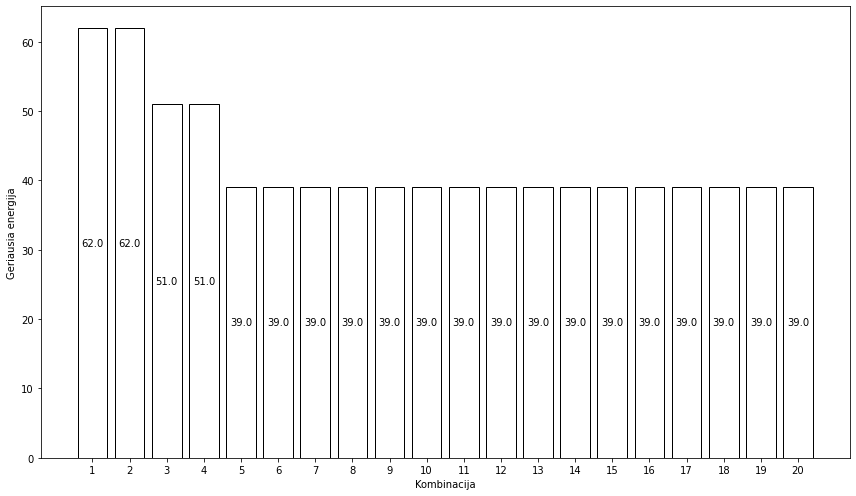

In [11]:
energies = [combo['best_energy'] for combo in sorted_combinationsHPPlusMinus]
combination_numbers = [combo['combination'] for combo in sorted_combinationsHPPlusMinus]

plt.figure(figsize=(12, 7))

bars = plt.bar(combination_numbers, energies, color='white', edgecolor='black')

plt.xlabel('Kombinacija')
plt.ylabel('Geriausia energija')
plt.xticks(list(range(1, 21)))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, round(yval, 2), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# Dalelių spiečiaus algoritmas

VEIKIMO PRINCIPAS: algoritmas naudoja dalelių spiečiaus principus, kur kiekviena dalelė juda tinkle, siekdama optimizuoti baltymo sulenkimą. Kiekvienos dalelės judėjimas yra nulemtas jos pačios geriausios padėties ir viso spiečiaus geriausios padėties. Kiekvienoje iteracijoje dalelėsatnaujina savo padėtis, siekdamos mažinti energijos lygį

H/P seka

In [2]:
def pso_protein_folding(seed):

    sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"
    hp_sequence = ''
    for amino_acid in sequence:
        if amino_acid in ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']:
            hp_sequence += 'H'
        else:
            hp_sequence += 'P'

    sequence = hp_sequence
    n = len(sequence)
    grid_size = 2 * n
    start_position = (grid_size // 2, grid_size // 2)

    def energy(folding):
        e = 0
        for i, (x1, y1) in enumerate(folding):
            for j, (x2, y2) in enumerate(folding):
                if abs(x1-x2) + abs(y1-y2) == 1 and sequence[i] == "H" and sequence[j] == "H" and i != j:
                    e -= 1
        return e / 2

    def move(folding, position):
        x, y = folding[position]
        moves = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        valid_moves = [m for m in moves if m not in folding and 0 <= m[0] < grid_size and 0 <= m[1] < grid_size]
        return valid_moves if valid_moves else [(x, y)]

    def random_initialize():
        folding = [start_position]
        for _ in range(1, n):
            folding.append(random.choice(move(folding, len(folding)-1)))
        return folding

    def ensure_boundaries(position):
        x, y = position
        x = max(0, min(grid_size - 1, x))
        y = max(0, min(grid_size - 1, y))
        return (x, y)

    num_particles = 30
    num_iterations = 100
    w = 0.5
    c1 = 1.5
    c2 = 1.5
    max_vel = 2

    particles = [random_initialize() for _ in range(num_particles)]
    velocities = [[(0, 0) for _ in range(n)] for _ in range(num_particles)]
    pbest_positions = particles.copy()
    pbest_scores = [energy(p) for p in particles]
    gbest_position = min(pbest_positions, key=energy)
    gbest_score = energy(gbest_position)

    for iteration in range(num_iterations):
        for i in range(num_particles):
            for j in range(1, n):
                rand1 = random.random()
                rand2 = random.random()

                cognitive_velocity = (c1 * rand1 * (pbest_positions[i][j][0] - particles[i][j][0]),
                                      c1 * rand1 * (pbest_positions[i][j][1] - particles[i][j][1]))

                social_velocity = (c2 * rand2 * (gbest_position[j][0] - particles[i][j][0]),
                                   c2 * rand2 * (gbest_position[j][1] - particles[i][j][1]))

                new_velocity = (w * velocities[i][j][0] + cognitive_velocity[0] + social_velocity[0],
                                w * velocities[i][j][1] + cognitive_velocity[1] + social_velocity[1])

                new_velocity = (max(-max_vel, min(max_vel, new_velocity[0])),
                                max(-max_vel, min(max_vel, new_velocity[1])))

                velocities[i][j] = new_velocity

                new_position = (particles[i][j][0] + velocities[i][j][0], particles[i][j][1] + velocities[i][j][1])
                new_position = ensure_boundaries(new_position)

                if new_position in move(particles[i], j):
                    particles[i][j] = new_position

            current_energy = energy(particles[i])
            if current_energy < pbest_scores[i]:
                pbest_positions[i] = particles[i].copy()
                pbest_scores[i] = current_energy

            if current_energy < gbest_score:
                gbest_position = particles[i].copy()
                gbest_score = current_energy
                
    return gbest_score, gbest_position

execution_times = []
best_energies = []
best_solutions = []

for i in range(10):
    random.seed(42) 
    start_time = time.time()
    best_energy, best_solution = pso_protein_folding(seed=i)
    end_time = time.time()
    execution_time = end_time - start_time
    
    execution_times.append(execution_time)
    best_energies.append(best_energy)
    best_solutions.append(best_solution)

df = pd.DataFrame({
    'Run': list(range(1, 11)),
    'Execution Time (s)': execution_times,
    'Best Energy': best_energies,
    'Best Solution': best_solutions
})

df.to_csv('particleswarm_results_HP.csv', index=False)
print(df)


def print_best_solution(solution):
    for idx, position in enumerate(solution):
        print(f"Amino Acid {idx + 1}: Position {position}")

print("\nBest Solution for Run 1:")
print_best_solution(best_solutions[0])

print("\nBest Solution for Run 2:")
print_best_solution(best_solutions[2])

   Run  Execution Time (s)  Best Energy  \
0    1           19.675620       -268.0   
1    2           19.743654       -268.0   
2    3           19.600030       -268.0   
3    4           20.574214       -268.0   
4    5           20.187270       -268.0   
5    6           19.154116       -268.0   
6    7           18.381294       -268.0   
7    8           17.637513       -268.0   
8    9           18.095652       -268.0   
9   10           18.160544       -268.0   

                                       Best Solution  
0  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
1  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
2  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
3  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
4  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
5  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
6  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
7  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
8  [(154, 154), (154, 153), (15

H/P/+/- seka

In [3]:
def pso_protein_folding():

    sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

    def classify_amino_acid(aa):
        hydrophobic = ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']
        polar = ['S', 'T', 'Y', 'N', 'Q']
        positive = ['K', 'R', 'H']
        negative = ['D', 'E']

        if aa in hydrophobic:
            return 'H'
        elif aa in polar:
            return 'P'
        elif aa in positive:
            return '+'
        elif aa in negative:
            return '-'

    sequence = ''.join([classify_amino_acid(aa) for aa in sequence])
    n = len(sequence)

    # Initialize grid
    grid_size = 2 * n
    start_position = (grid_size // 2, grid_size // 2)

    def energy(folding):
        e = 0
        for i, (x1, y1) in enumerate(folding):
            for j, (x2, y2) in enumerate(folding):
                if abs(x1-x2) + abs(y1-y2) == 1 and sequence[i] == "H" and sequence[j] == "H" and i != j:
                    e -= 1
        return e / 2

    def move(folding, position):
        x, y = folding[position]
        moves = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        valid_moves = [m for m in moves if m not in folding and 0 <= m[0] < grid_size and 0 <= m[1] < grid_size]
        return valid_moves if valid_moves else [(x, y)]

    def random_initialize():
        folding = [start_position]
        for _ in range(1, n):
            folding.append(random.choice(move(folding, len(folding)-1)))
        return folding

    def ensure_boundaries(position):
        x, y = position
        x = max(0, min(grid_size - 1, x))
        y = max(0, min(grid_size - 1, y))
        return (x, y)

    num_particles = 30
    num_iterations = 100
    w = 0.5
    c1 = 1.5
    c2 = 1.5
    max_vel = 2

    particles = [random_initialize() for _ in range(num_particles)]
    velocities = [[(0, 0) for _ in range(n)] for _ in range(num_particles)]
    pbest_positions = particles.copy()
    pbest_scores = [energy(p) for p in particles]
    gbest_position = min(pbest_positions, key=energy)
    gbest_score = energy(gbest_position)

    for iteration in range(num_iterations):
        for i in range(num_particles):
            for j in range(1, n):
                rand1 = random.random()
                rand2 = random.random()

                cognitive_velocity = (c1 * rand1 * (pbest_positions[i][j][0] - particles[i][j][0]),
                                      c1 * rand1 * (pbest_positions[i][j][1] - particles[i][j][1]))

                social_velocity = (c2 * rand2 * (gbest_position[j][0] - particles[i][j][0]),
                                   c2 * rand2 * (gbest_position[j][1] - particles[i][j][1]))

                new_velocity = (w * velocities[i][j][0] + cognitive_velocity[0] + social_velocity[0],
                                w * velocities[i][j][1] + cognitive_velocity[1] + social_velocity[1])

                new_velocity = (max(-max_vel, min(max_vel, new_velocity[0])),
                                max(-max_vel, min(max_vel, new_velocity[1])))

                velocities[i][j] = new_velocity

                new_position = (particles[i][j][0] + velocities[i][j][0], particles[i][j][1] + velocities[i][j][1])
                new_position = ensure_boundaries(new_position)

                if new_position in move(particles[i], j):
                    particles[i][j] = new_position

            current_energy = energy(particles[i])
            if current_energy < pbest_scores[i]:
                pbest_positions[i] = particles[i].copy()
                pbest_scores[i] = current_energy

            if current_energy < gbest_score:
                gbest_position = particles[i].copy()
                gbest_score = current_energy
                
    return gbest_score, gbest_position

execution_times = []
best_energies = []
best_solutions = []

for i in range(10):
    random.seed(42)  
    start_time = time.time()
    best_energy, best_solution = pso_protein_folding()
    end_time = time.time()
    execution_time = end_time - start_time
    
    execution_times.append(execution_time)
    best_energies.append(best_energy)
    best_solutions.append(best_solution)

df = pd.DataFrame({
    'Run': list(range(1, 11)),
    'Execution Time (s)': execution_times,
    'Best Energy': best_energies,
    'Best Solution': best_solutions
})

df.to_csv('particleswarm_results_HPPLusMinus.csv', index=False)
print(df)

def print_best_solution(solution):
    for idx, position in enumerate(solution):
        print(f"Amino Acid {idx + 1}: Position {position}")

print("\nBest Solution for Run 1:")
print_best_solution(best_solutions[0])

print("\nBest Solution for Run 2:")
print_best_solution(best_solutions[2])

   Run  Execution Time (s)  Best Energy  \
0    1           19.748192       -268.0   
1    2           18.940452       -268.0   
2    3           19.076678       -268.0   
3    4           18.647624       -268.0   
4    5           18.634369       -268.0   
5    6           19.752420       -268.0   
6    7           19.405079       -268.0   
7    8           18.459711       -268.0   
8    9           19.488049       -268.0   
9   10           18.586436       -268.0   

                                       Best Solution  
0  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
1  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
2  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
3  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
4  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
5  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
6  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
7  [(154, 154), (154, 153), (155.0, 153.0), (155,...  
8  [(154, 154), (154, 153), (15

# Tabu paieška

VEIKIMO PRINCIPAS: algoritmas pradeda su atsitiktine baltymo lankstymosi konfigūracija tinklelyje ir ieško kaimyninių sprendimų, neleisdama grįžti į „tabu“' pažymėtas pozicijas tam tikrą skaičių iteracijų. Kiekvienas naujas, geresnis sprendimas yra įrašomas ir, jei jis gerina energijos lygį, tampa nauju geriausiu sprendimu. Paieška nebūtinai prasideda nuo nulio kokiu nors konkrečiu požiūriu, o veikiau nuo atsitiktinai sugeneruoto pradinio sprendimo tinklelyje. Kiekvieno algoritmo paleidimo metu bus pradedama nuo skirtingos pradinės konfigūracijos, nes pradinės pozicijos nustatomos pagal pseudo-atsitiktinių skaičių generatorių, kuris sėklintas siekiant rezultatų atkartojamumo.

H/P seka

In [5]:
def tabu_search_protein_folding():
    sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"
    hp_sequence = ''
    for amino_acid in sequence:
        if amino_acid in ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']:
            hp_sequence += 'H'
        else:
            hp_sequence += 'P'

    sequence = hp_sequence
    n = len(sequence)
    grid_size = 2 * n

    def initial_solution():
        positions = [(random.randint(0, grid_size-1), random.randint(0, grid_size-1)) for _ in range(n)]
        return positions

    def energy(folding):
        e = 0
        for i, (x1, y1) in enumerate(folding):
            for j, (x2, y2) in enumerate(folding):
                if abs(x1 - x2) + abs(y1 - y2) == 1 and i != j:
                    if sequence[i] == sequence[j]:
                        e -= 1
                    else:
                        e += 1
        return e / 2

    def generate_neighbors(current_solution, tabu_list):
        neighbors = []
        for i in range(n):
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                x, y = current_solution[i]
                neighbor = copy.deepcopy(current_solution)
                neighbor[i] = (x + dx, y + dy)
                if neighbor[i] not in tabu_list:
                    neighbors.append(neighbor)
        return neighbors

    max_iterations = 10
    tabu_list_size = 50
    current_solution = initial_solution()
    best_solution = copy.deepcopy(current_solution)
    best_energy = energy(best_solution)
    tabu_list = []

    for iteration in range(max_iterations):
        neighbors = generate_neighbors(current_solution, tabu_list)
        best_neighbor = min(neighbors, key=energy)
        best_neighbor_energy = energy(best_neighbor)
        current_solution = best_neighbor
        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_list_size:
            tabu_list.pop(0)
        if best_neighbor_energy < best_energy:
            best_solution = best_neighbor
            best_energy = best_neighbor_energy
    
    return best_energy, best_solution

execution_times = []
best_energies = []
best_solutions = []

random_seed = 12345

for i in range(10):
    random.seed(random_seed)
    start_time = time.time()
    best_energy, best_solution = tabu_search_protein_folding()
    end_time = time.time()
    execution_time = end_time - start_time
    
    execution_times.append(execution_time)
    best_energies.append(best_energy)
    best_solutions.append(best_solution)

df = pd.DataFrame({
    'Run': list(range(1, 11)),
    'Execution Time (s)': execution_times,
    'Best Energy': best_energies,
    'Best Solution': best_solutions
})

df.to_csv('tabu_search_results_HP.csv', index=False)

print(df)

def print_best_solution(solution):
    for idx, position in enumerate(solution):
        print(f"Amino Acid {idx + 1}: Position {position}")

print("\nBest Solution for Run 1:")
print_best_solution(best_solutions[0])

print("\nBest Solution for Run 2:")
print_best_solution(best_solutions[1])

   Run  Execution Time (s)  Best Energy  \
0    1           34.437565         -2.0   
1    2           36.347740         -2.0   
2    3           36.188147         -2.0   
3    4           35.566061         -2.0   
4    5           35.775549         -2.0   
5    6           34.957030         -2.0   
6    7           36.951100         -2.0   
7    8           37.378333         -2.0   
8    9           36.957957         -2.0   
9   10           36.049628         -2.0   

                                       Best Solution  
0  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
1  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
2  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
3  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
4  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
5  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
6  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
7  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
8  [(213, 5), (153, 188), (99, 

H/P/+/-

In [6]:
def tabu_search_protein_folding():
    sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

    def classify_amino_acid(aa):
        hydrophobic = ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']
        polar = ['S', 'T', 'Y', 'N', 'Q']
        positive = ['K', 'R', 'H']
        negative = ['D', 'E']

        if aa in hydrophobic:
            return 'H'
        elif aa in polar:
            return 'P'
        elif aa in positive:
            return '+'
        elif aa in negative:
            return '-'

    sequence = ''.join([classify_amino_acid(aa) for aa in sequence])
    n = len(sequence)

    grid_size = 2 * n
    start_position = (grid_size // 2, grid_size // 2)

    def initial_solution():
        positions = [(random.randint(0, grid_size-1), random.randint(0, grid_size-1)) for _ in range(n)]
        return positions

    def energy(folding):
        e = 0
        for i, (x1, y1) in enumerate(folding):
            for j, (x2, y2) in enumerate(folding):
                if abs(x1 - x2) + abs(y1 - y2) == 1 and i != j:
                    if sequence[i] == sequence[j]:
                        e -= 1
                    else:
                        e += 1
        return e / 2

    def generate_neighbors(current_solution, tabu_list):
        neighbors = []
        for i in range(n):
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                x, y = current_solution[i]
                neighbor = copy.deepcopy(current_solution)
                neighbor[i] = (x + dx, y + dy)
                if neighbor[i] not in tabu_list:
                    neighbors.append(neighbor)
        return neighbors

    max_iterations = 10
    tabu_list_size = 50
    current_solution = initial_solution()
    best_solution = copy.deepcopy(current_solution)
    best_energy = energy(best_solution)
    tabu_list = []

    for iteration in range(max_iterations):
        neighbors = generate_neighbors(current_solution, tabu_list)
        best_neighbor = min(neighbors, key=energy)
        best_neighbor_energy = energy(best_neighbor)
        current_solution = best_neighbor
        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_list_size:
            tabu_list.pop(0)
        if best_neighbor_energy < best_energy:
            best_solution = best_neighbor
            best_energy = best_neighbor_energy
    
    return best_energy, best_solution

execution_times = []
best_energies = []
best_solutions = []

random_seed = 12345

for i in range(10):
    random.seed(random_seed)  
    start_time = time.time()
    best_energy, best_solution = tabu_search_protein_folding()
    end_time = time.time()
    execution_time = end_time - start_time
    
    execution_times.append(execution_time)
    best_energies.append(best_energy)
    best_solutions.append(best_solution)

df = pd.DataFrame({
    'Run': list(range(1, 11)),
    'Execution Time (s)': execution_times,
    'Best Energy': best_energies,
    'Best Solution': best_solutions
})

df.to_csv('tabu_search_results_HPPlusMinus.csv', index=False)

print(df)

def print_best_solution(solution):
    for idx, position in enumerate(solution):
        print(f"Amino Acid {idx + 1}: Position {position}")

print("\nBest Solution for Run 1:")
print_best_solution(best_solutions[0])

print("\nBest Solution for Run 2:")
print_best_solution(best_solutions[1]) 

   Run  Execution Time (s)  Best Energy  \
0    1           33.106854         -1.0   
1    2           36.982128         -1.0   
2    3           38.453309         -1.0   
3    4           36.877182         -1.0   
4    5           38.986161         -1.0   
5    6           38.571856         -1.0   
6    7           36.691946         -1.0   
7    8           35.277805         -1.0   
8    9           37.719245         -1.0   
9   10           36.680673         -1.0   

                                       Best Solution  
0  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
1  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
2  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
3  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
4  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
5  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
6  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
7  [(213, 5), (153, 188), (99, 138), (289, 223), ...  
8  [(213, 5), (153, 188), (99, 

# Monte Karlo

VEIKIMO PRINCIPAS: metodas taikytas iteratyviai lenkiant baltymą tinkle. Šis veiksmas prasideda nuo pradinio lenkimo konfigūracijos, ir kiekviename žingsnyje atsitiktinai pasirenkama pozicija, tuomet bandomas judėjimas, priimant judėjimus, kurie mažina energiją arba turi tikimybę, nustatytą temperatūros parametru. Procesas kartojamas nurodytą žingsnių skaičių. Geriausia rasta energijos konfigūracija išlieka kaip optimizuota baltymo struktūra

H/P seka

In [7]:
random.seed(0)

sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

hp_sequence = ''
for amino_acid in sequence:
    if amino_acid in ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']:
        hp_sequence += 'H'
    else:
        hp_sequence += 'P'

sequence = hp_sequence
n = len(sequence)
grid_size = 2 * n
start_position = (grid_size // 2, grid_size // 2)

def energy_delta(folding, old_pos, new_pos, index):
    delta_energy = 0
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    for dx, dy in directions:
        neighbor_old = (old_pos[0] + dx, old_pos[1] + dy)
        neighbor_new = (new_pos[0] + dx, new_pos[1] + dy)

        if neighbor_old in folding and folding.index(neighbor_old) != index:
            if sequence[index] == sequence[folding.index(neighbor_old)]:
                delta_energy += 1
            else:
                delta_energy -= 1

        if neighbor_new in folding and folding.index(neighbor_new) != index:
            if sequence[index] == sequence[folding.index(neighbor_new)]:
                delta_energy -= 1
            else:
                delta_energy += 1

    return delta_energy

def move(folding):
    index = random.randint(0, len(folding) - 1)
    x, y = folding[index]
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    dx, dy = random.choice(directions)
    new_x, new_y = x + dx, y + dy
    if (new_x, new_y) in folding or new_x < 0 or new_y < 0 or new_x >= grid_size or new_y >= grid_size:
        return folding, 0
    new_folding = folding.copy()
    new_folding[index] = (new_x, new_y)
    delta_e = energy_delta(new_folding, (x, y), (new_x, new_y), index)
    return new_folding, delta_e

def monte_carlo(steps):
    folding = [(start_position[0] + i, start_position[1]) for i in range(n)]
    best_folding = folding[:]
    best_e = energy(folding)
    current_e = best_e
    T_initial = 10
    T = T_initial

    for step in range(steps):
        new_folding, delta_e = move(folding)
        new_e = current_e + delta_e
        
        if new_e < best_e:
            best_folding, best_e = new_folding[:], new_e

        if delta_e < 0 or random.uniform(0, 1) < math.exp(-delta_e / T):
            folding = new_folding
            current_e = new_e

        T = T_initial * (1 - step / steps)

    return best_e, best_folding

def energy(folding):
    e = 0
    for i, (x1, y1) in enumerate(folding):
        for j, (x2, y2) in enumerate(folding):
            if abs(x1 - x2) + abs(y1 - y2) == 1 and i != j:
                if sequence[i] == sequence[j]:
                    e -= 1
                else:
                    e += 1
    return e // 2

execution_times = []
best_energies = []
best_solutions = []

for i in range(10):
    random.seed(0)  
    start_time = time.time()
    best_energy, best_solution = monte_carlo(10000)
    end_time = time.time()
    execution_time = end_time - start_time
    
    execution_times.append(execution_time)
    best_energies.append(best_energy)
    best_solutions.append(best_solution)

df = pd.DataFrame({
    'Run': list(range(1, 11)),
    'Execution Time (s)': execution_times,
    'Best Energy': best_energies,
    'Best Solution': best_solutions
})

df.to_csv('montecarlo_results_HP.csv', index=False)
print(df)

def print_best_solution(solution):
    for idx, position in enumerate(solution):
        print(f"Amino Acid {idx + 1}: Position {position}")

print("\nBest Solution for Run 1:")
print_best_solution(best_solutions[0])

   Run  Execution Time (s)  Best Energy  \
0    1            0.378815          -37   
1    2            0.315645          -37   
2    3            0.323061          -37   
3    4            0.421604          -37   
4    5            0.493316          -37   
5    6            0.406708          -37   
6    7            0.600207          -37   
7    8            0.424803          -37   
8    9            0.457963          -37   
9   10            0.427391          -37   

                                       Best Solution  
0  [(154, 149), (153, 149), (147, 157), (155, 152...  
1  [(154, 149), (153, 149), (147, 157), (155, 152...  
2  [(154, 149), (153, 149), (147, 157), (155, 152...  
3  [(154, 149), (153, 149), (147, 157), (155, 152...  
4  [(154, 149), (153, 149), (147, 157), (155, 152...  
5  [(154, 149), (153, 149), (147, 157), (155, 152...  
6  [(154, 149), (153, 149), (147, 157), (155, 152...  
7  [(154, 149), (153, 149), (147, 157), (155, 152...  
8  [(154, 149), (153, 149), (14

H/P/+/- seka

In [8]:
random.seed(0)

sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

def classify_amino_acid(aa):
    hydrophobic = ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']
    polar = ['S', 'T', 'Y', 'N', 'Q']
    positive = ['K', 'R', 'H']
    negative = ['D', 'E']

    if aa in hydrophobic:
        return 'H'
    elif aa in polar:
        return 'P'
    elif aa in positive:
        return '+'
    elif aa in negative:
        return '-'

sequence = ''.join([classify_amino_acid(aa) for aa in sequence])
n = len(sequence)

grid_size = 2 * n
start_position = (grid_size // 2, grid_size // 2)

def energy_delta(folding, old_pos, new_pos, index):
    delta_energy = 0
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    for dx, dy in directions:
        neighbor_old = (old_pos[0] + dx, old_pos[1] + dy)
        neighbor_new = (new_pos[0] + dx, new_pos[1] + dy)

        if neighbor_old in folding and folding.index(neighbor_old) != index:
            if sequence[index] == sequence[folding.index(neighbor_old)]:
                delta_energy += 1
            else:
                delta_energy -= 1

        if neighbor_new in folding and folding.index(neighbor_new) != index:
            if sequence[index] == sequence[folding.index(neighbor_new)]:
                delta_energy -= 1
            else:
                delta_energy += 1

    return delta_energy

def move(folding):
    index = random.randint(0, len(folding) - 1)
    x, y = folding[index]
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    dx, dy = random.choice(directions)
    new_x, new_y = x + dx, y + dy
    if (new_x, new_y) in folding or new_x < 0 or new_y < 0 or new_x >= grid_size or new_y >= grid_size:
        return folding, 0
    new_folding = folding.copy()
    new_folding[index] = (new_x, new_y)
    delta_e = energy_delta(new_folding, (x, y), (new_x, new_y), index)
    return new_folding, delta_e

def monte_carlo(steps):
    folding = [(start_position[0] + i, start_position[1]) for i in range(n)]
    best_folding = folding[:]
    best_e = energy(folding)
    current_e = best_e
    T_initial = 10
    T = T_initial

    for step in range(steps):
        new_folding, delta_e = move(folding)
        new_e = current_e + delta_e
        
        if new_e < best_e:
            best_folding, best_e = new_folding[:], new_e

        if delta_e < 0 or random.uniform(0, 1) < math.exp(-delta_e / T):
            folding = new_folding
            current_e = new_e

        T = T_initial * (1 - step / steps)

    return best_e, best_folding

def energy(folding):
    e = 0
    for i, (x1, y1) in enumerate(folding):
        for j, (x2, y2) in enumerate(folding):
            if abs(x1 - x2) + abs(y1 - y2) == 1 and i != j:
                if sequence[i] == sequence[j]:
                    e -= 1
                else:
                    e += 1
    return e // 2

execution_times = []
best_energies = []
best_solutions = []

for i in range(10):
    random.seed(0)
    start_time = time.time()
    best_energy, best_solution = monte_carlo(10000)
    end_time = time.time()
    execution_time = end_time - start_time
    
    execution_times.append(execution_time)
    best_energies.append(best_energy)
    best_solutions.append(best_solution)

df = pd.DataFrame({
    'Run': list(range(1, 11)),
    'Execution Time (s)': execution_times,
    'Best Energy': best_energies,
    'Best Solution': best_solutions
})

df.to_csv('montecarlo_results_HPPlusMinus.csv', index=False)
print(df)

def print_best_solution(solution):
    for idx, position in enumerate(solution):
        print(f"Amino Acid {idx + 1}: Position {position}")

print("\nBest Solution for Run 1:")
print_best_solution(best_solutions[0])

   Run  Execution Time (s)  Best Energy  \
0    1            0.473995          -20   
1    2            0.437701          -20   
2    3            0.462889          -20   
3    4            0.491981          -20   
4    5            0.396976          -20   
5    6            0.392625          -20   
6    7            0.376280          -20   
7    8            0.413954          -20   
8    9            0.374158          -20   
9   10            0.454502          -20   

                                       Best Solution  
0  [(156, 144), (161, 147), (151, 158), (157, 151...  
1  [(156, 144), (161, 147), (151, 158), (157, 151...  
2  [(156, 144), (161, 147), (151, 158), (157, 151...  
3  [(156, 144), (161, 147), (151, 158), (157, 151...  
4  [(156, 144), (161, 147), (151, 158), (157, 151...  
5  [(156, 144), (161, 147), (151, 158), (157, 151...  
6  [(156, 144), (161, 147), (151, 158), (157, 151...  
7  [(156, 144), (161, 147), (151, 158), (157, 151...  
8  [(156, 144), (161, 147), (15

# Rezultatų analizė

Kodo įvykdymo laiko vidurkio apskaičiavimas

ACO H/P

In [17]:
df_ACOHP = pd.read_csv('aco_results_HP.csv')

mean_execution_time_ACOHP = df_ACOHP['Execution Time (s)'].mean()

print("Mean Execution Time:", mean_execution_time_ACOHP)

Mean Execution Time: 899.4449889183045


In [18]:
mean_execution_time_ACOHP_minutes = mean_execution_time_ACOHP / 60

print("Mean Execution Time:", mean_execution_time_ACOHP_minutes, "minutes")

Mean Execution Time: 14.990749815305074 minutes


ACO H/P/+/-

In [18]:
df_ACOHPPlusMinus = pd.read_csv('aco_results_HPPlusMinus.csv')

mean_execution_time_ACOHPPLusMinus = df_ACOHPPlusMinus['Execution Time (s)'].mean()

print("Mean Execution Time:", mean_execution_time_ACOHPPLusMinus)

Mean Execution Time: 997.2804358243942


In [24]:
mean_execution_time_ACOHPPlusMinus_minutes = mean_execution_time_ACOHPPLusMinus / 60

print("Mean Execution Time:", mean_execution_time_ACOHPPlusMinus_minutes, "minutes")

Mean Execution Time: 16.621340597073235 minutes


Particle H/P

In [23]:
df_ParticleHP = pd.read_csv('particleswarm_results_HP.csv')

mean_execution_time_ParticleHP = df_ParticleHP['Execution Time (s)'].mean()

print("Mean Execution Time:", mean_execution_time_ParticleHP)

Mean Execution Time: 19.12099072933197


In [25]:
mean_execution_time_ParticleHP_minutes = mean_execution_time_ParticleHP / 60

print("Mean Execution Time:", mean_execution_time_ParticleHP_minutes, "minutes")

Mean Execution Time: 0.31868317882219954 minutes


Particle H/P/+/-

In [3]:
df_ParticleHPPlusMinus = pd.read_csv('particleswarm_results_HPPlusMinus.csv')

mean_execution_time_ParticleHPPlusMinus = df_ParticleHPPlusMinus['Execution Time (s)'].mean()

print("Mean Execution Time:", mean_execution_time_ParticleHPPlusMinus)

Mean Execution Time: 19.07390103340149


In [5]:
mean_execution_time_ParticleHP_minutes = mean_execution_time_ParticleHPPlusMinus / 60

print("Mean Execution Time:", mean_execution_time_ParticleHP_minutes, "minutes")

Mean Execution Time: 0.3178983505566915 minutes


Tabu H/P

In [8]:
df_TabuHP = pd.read_csv('tabu_search_results_HP.csv')

mean_execution_time_TabuHP = df_TabuHP['Execution Time (s)'].mean()

print("Mean Execution Time:", mean_execution_time_TabuHP)

Mean Execution Time: 36.06091091632843


In [9]:
mean_execution_time_TabuHP = mean_execution_time_TabuHP / 60

print("Mean Execution Time:", mean_execution_time_TabuHP, "minutes")

Mean Execution Time: 0.6010151819388072 minutes


Tabu H/P/+/-

In [10]:
df_TabuHPPlusMinus = pd.read_csv('tabu_search_results_HPPlusMinus.csv')

mean_execution_time_TabuHPPlusMinus = df_TabuHP['Execution Time (s)'].mean()

print("Mean Execution Time:", mean_execution_time_TabuHPPlusMinus)

Mean Execution Time: 36.06091091632843


In [11]:
mean_execution_time_TabuHPPlusMinus = mean_execution_time_TabuHPPlusMinus / 60

print("Mean Execution Time:", mean_execution_time_TabuHPPlusMinus, "minutes")

Mean Execution Time: 0.6010151819388072 minutes


Monte Karlo H/P

In [14]:
df_MonteKarloHP = pd.read_csv('montecarlo_results_HP.csv')

mean_execution_time_MonteKarloHP = df_MonteKarloHP['Execution Time (s)'].mean()

print("Mean Execution Time:", mean_execution_time_MonteKarloHP)

Mean Execution Time: 0.4249510526657104


In [15]:
mean_execution_time_MonteKarloHP = mean_execution_time_MonteKarloHP / 60

print("Mean Execution Time:", mean_execution_time_MonteKarloHP, "minutes")

Mean Execution Time: 0.0070825175444285075 minutes


Monte Karlo H/P/+/-

In [16]:
df_MonteKarloHPPlusMinus = pd.read_csv('montecarlo_results_HPPlusMinus.csv')

mean_execution_time_MonteKarloHPPlusMinus = df_MonteKarloHPPlusMinus['Execution Time (s)'].mean()

print("Mean Execution Time:", mean_execution_time_MonteKarloHPPlusMinus)

Mean Execution Time: 0.4275060176849365


In [17]:
mean_execution_time_MonteKarloHPPlusMinus = mean_execution_time_MonteKarloHPPlusMinus / 60

print("Mean Execution Time:", mean_execution_time_MonteKarloHPPlusMinus, "minutes")

Mean Execution Time: 0.007125100294748942 minutes


Baltymo sekos vizualizavimas

In [8]:
sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

positions = [
    # Nurodomos apskaičiuotos baltymo pozicijos
]

structure = Model.Model(0)
chain = Chain.Chain("A")

for i, (x, y) in enumerate(positions):
    res_id = (" ", i+1, " ")
    res = Residue.Residue(res_id, sequence[i], " ")
    atom = Atom.Atom('CA', [x, y, 0], 0, 0, " ", 'CA', i+1, "C")  # Use X, Y for position, Z=0
    res.add(atom)
    chain.add(res)

structure.add(chain)

io = PDBIO()
io.set_structure(structure)
pdb_filename = "MonteKarlo_HPPlusMinus.pdb"
io.save(pdb_filename)

view = py3Dmol.view(width=800, height=400)
view.addModel(open(pdb_filename, 'r').read(), format="pdb")
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Sugeneruotas PDB failas keliamas čia: https://nglviewer.org/ngl/

# Eenrgijos ir laiko grafikai

H/P seka

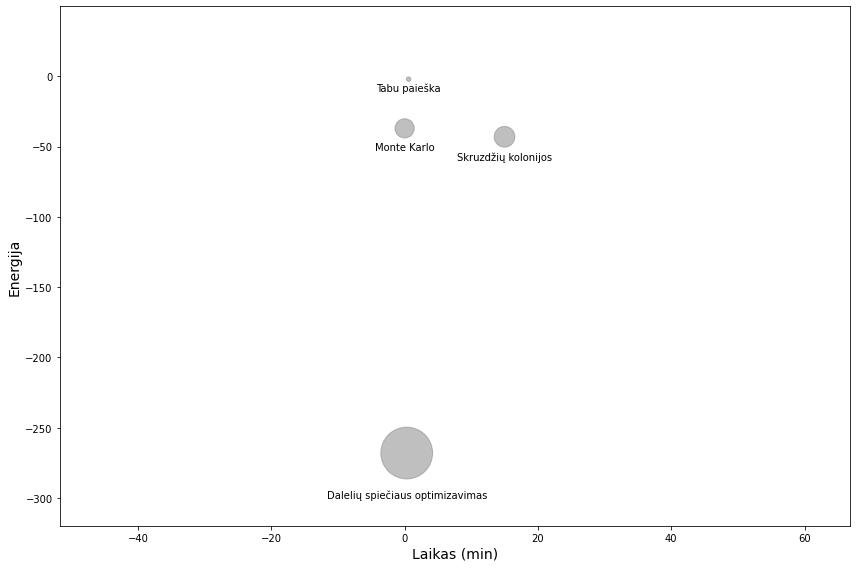

In [30]:
methods = ['Skruzdžių kolonijos', 'Tabu paieška', 'Dalelių spiečiaus optimizavimas', 'Monte Karlo']
time = [14.990749815305074, 0.6010151819388072, 0.31868317882219954, 0.0070825175444285075] 
energy = [-43, -2, -268, -37]  # Energy values

bubble_size = [abs(e) * 10 for e in energy]

plt.figure(figsize=(12, 8))
plt.scatter(time, energy, s=bubble_size, alpha=0.5, color='grey') 

plt.xlabel('Laikas (min)', fontsize=14)
plt.ylabel('Energija', fontsize=14)

offsets = [bs**0.5 for bs in bubble_size]

for i, method in enumerate(methods):
    if energy[i] < 0:
        plt.text(time[i], energy[i] - offsets[i]*0.5, method, ha='center', va='top', color='black', fontsize=10)
    else:
        plt.text(time[i], energy[i] + offsets[i]*0.5, method, ha='center', va='bottom', color='black', fontsize=10)

x_offset = max(offsets)
y_offset = max(offsets)
plt.xlim(left=min(time) - x_offset, right=max(time) + x_offset)
plt.ylim(bottom=min(energy) - y_offset, top=max(energy) + y_offset)

plt.tight_layout()
plt.show()

H/P/+/-

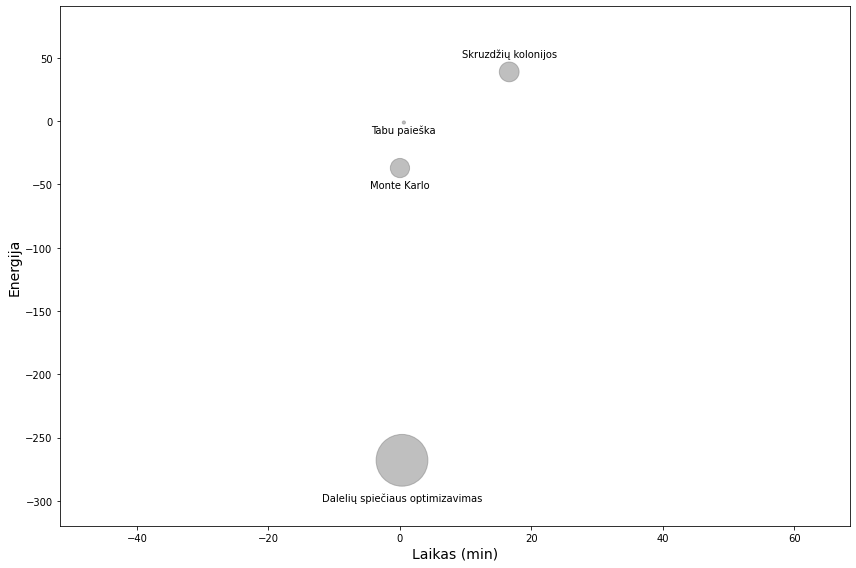

In [31]:
methods = ['Skruzdžių kolonijos', 'Tabu paieška', 'Dalelių spiečiaus optimizavimas', 'Monte Karlo']
time = [16.621340597073235, 0.6010151819388072, 0.3178983505566915, 0.007125100294748942] 
energy = [39, -1, -268, -37]

bubble_size = [abs(e) * 10 for e in energy] 

plt.figure(figsize=(12, 8))
plt.scatter(time, energy, s=bubble_size, alpha=0.5, color='grey')

plt.xlabel('Laikas (min)', fontsize=14)
plt.ylabel('Energija', fontsize=14)

offsets = [bs**0.5 for bs in bubble_size]

for i, method in enumerate(methods):
    if energy[i] < 0:
        plt.text(time[i], energy[i] - offsets[i]*0.5, method, ha='center', va='top', color='black', fontsize=10)
    else:
        plt.text(time[i], energy[i] + offsets[i]*0.5, method, ha='center', va='bottom', color='black', fontsize=10)

x_offset = max(offsets)
y_offset = max(offsets)
plt.xlim(left=min(time) - x_offset, right=max(time) + x_offset)
plt.ylim(bottom=min(energy) - y_offset, top=max(energy) + y_offset)

plt.tight_layout()
plt.show()